In [1]:
import pandas as pd
from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
# This saves fonts as fonts in the svg and not as shapes
plt.rcParams['svg.fonttype'] = 'none'

import numpy as np
from scipy.stats import mannwhitneyu as MWU

import warnings
warnings.filterwarnings('ignore')

## Data Load

We assign a BASAL region to each gene, it starts from its TSS and extends 5kb upstream and 1kb downstream, or untill it encounters another TSS.

For the GREAT region, we extend the BASAL region UP TO 1Mb in each way, or until a BASAL region of another gene is encountered.    
     
Here, we load and use the GREAT regions

In [2]:
greg = {}

greg['Dre'] = pd.read_csv("./data/genomic_regions/GREAT_dre.bed", sep='\t', header=None)
greg['Dre'].columns = ['chrom','start','end','geneID','score','strand']
greg['Dre']['score'] = greg['Dre']['end'] - greg['Dre']['start']

greg['Bla'] = pd.read_csv("./data/genomic_regions/GREAT_bla.bed", sep='\t', header=None)
greg['Bla'].columns = ['chrom','start','end','geneID','score','strand']
greg['Bla']['score'] = greg['Bla']['end'] - greg['Bla']['start']

greg['Ola'] = pd.read_csv("./data/genomic_regions/GREAT_ola.bed", sep='\t', header=None)
greg['Ola'].columns = ['chrom','start','end','geneID','score','strand']
greg['Ola']['score'] = greg['Ola']['end'] - greg['Ola']['start']

greg['Mmu'] = pd.read_csv("./data/genomic_regions/GREAT_mmu.bed", sep='\t', header=None)
greg['Mmu'].columns = ['chrom','start','end','geneID','score','strand']
greg['Mmu']['score'] = greg['Mmu']['end'] - greg['Mmu']['start']

print( [(k,len(v)) for k,v in greg.items()])

[('Dre', 20053), ('Bla', 20569), ('Ola', 15978), ('Mmu', 18842)]


In [3]:
greg['Mmu'].head()

,chrom,start,end,geneID,score,strand
0,chr1,2670503,4359310,ENSMUSG00000051951,1688807,-
1,chr1,3676503,4495409,ENSMUSG00000025900,818906,-
2,chr1,4365319,4784706,ENSMUSG00000025902,419387,-
3,chr1,4501418,4802819,ENSMUSG00000033845,301401,-
4,chr1,4790715,4852810,ENSMUSG00000025903,62095,+


In [4]:
stages = {}
stages['Bla'] = ['8','15','36','60']
stages['Dre'] = ["dome","shield","80epi","8som","24h","48h"]
stages['Ola'] = ["dome","shield","8som","24h","48h"]
stages['Mmu'] = ['DE','ESC']

### The ATAC-seq peaks

As determined by the idr "pipeline", see more in the peak-calling notebook

In [5]:
pre_ = './data/atac_peaks/'

peak_beds = {}

peak_beds['Dre'] = [ (BT("{}zebra_danRer10_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Dre']]
peak_beds['Bla'] = [(BT("{}amphi_{}_idrpeaks.bed".format(pre_,x))
                     .sort()
                     ) for x in stages['Bla']]
peak_beds['Ola'] = [ (BT("{}medaka_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Ola']]
peak_beds['Mmu'] = [ (BT("{}mouse_{}_idrpeaks.bed".format(pre_,x))
                    .sort()
                    )for x in stages['Mmu']]


In [6]:
fate_dict_zebra = dict(pd.read_csv("./data/gene_fates/Spec_genes_byLost-Dre-v3.txt", sep='\t',header=None).set_index(0)[1])
fate_dict_mouse = dict(pd.read_csv("./data/gene_fates/Spec_genes_byLost-Mmu-v3.txt", sep='\t',header=None).set_index(0)[1])

In [8]:
bedfields = ['chrom','start','end','name','score','strand']
big = {}

big['Dre'] = BT().from_dataframe(greg['Dre']).sort()
for bee in peak_beds['Dre']:
    big['Dre'] = big['Dre'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Dre'] = big['Dre'].to_dataframe()
big['Dre'].columns = bedfields + stages['Dre']

big['Mmu'] = BT().from_dataframe(greg['Mmu']).sort()
for bee in peak_beds['Mmu']:
    big['Mmu'] = big['Mmu'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Mmu'] = big['Mmu'].to_dataframe()
big['Mmu'].columns = bedfields + stages['Mmu']

In [9]:
big['Dre'].sample(5)

,chrom,start,end,name,score,strand,dome,shield,80epi,8som,24h,48h
3096,chr13,2318446,2392107,ENSDARG00000099997,73661,-,6,7,7,9,9,9
8292,chr2,6325640,6349555,ENSDARG00000039830,23915,+,3,2,3,2,2,2
212,chr1,13245188,13328892,ENSDARG00000079626,83704,-,10,10,15,19,19,20
6089,chr17,5617105,5702122,ENSDARG00000089458,85017,+,7,4,6,11,8,9
6063,chr17,2645654,2686527,ENSDARG00000020744,40873,-,3,2,3,4,4,5


In [29]:
dre_melt = pd.melt(big['Dre'][['name']+stages['Dre']], id_vars='name')
dre_melt['DomL'] = dre_melt['name'].map(fate_dict_zebra)
dre_melt = dre_melt.dropna()

In [30]:
mmu_melt = pd.melt(big['Mmu'][['name']+stages['Mmu']], id_vars='name')
mmu_melt['DomL'] = mmu_melt['name'].map(fate_dict_mouse)
mmu_melt = mmu_melt.dropna()

In [36]:
mergerdic = {0 : '0',
            1 : '1-2',
            2: '1-2',
            3: '3-4',
            4: '3-4',
            5: '5-6',
            6: '5-6',
            7: '7+',
            8: '7+',
            9: '7+'}

In [46]:
dre_melt['mergedfate'] = dre_melt.DomL.map(mergerdic)
mmu_melt['mergedfate'] = mmu_melt.DomL.map(mergerdic)

In [38]:
dre_melt.head(2)

,name,variable,value,DomL,mergedfate
28,ENSDARG00000100181,dome,6,1.0,1-2
32,ENSDARG00000041592,dome,4,1.0,1-2


(0, 55)

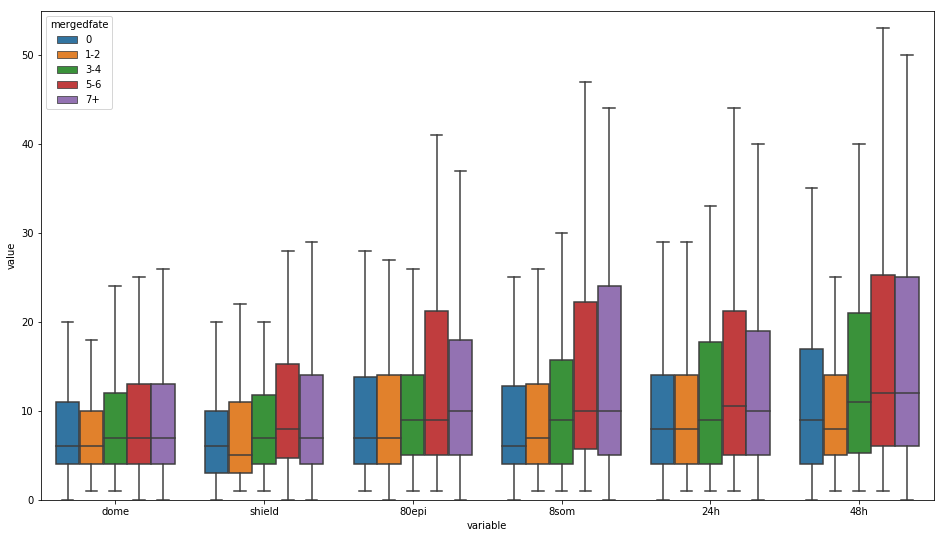

In [41]:
# All stages of zebra:
plt.figure(figsize=(16,9))
sns.boxplot( data=dre_melt, 
           y='value',
           x='variable',
            hue='mergedfate',
        fliersize=0,
            hue_order = ['0','1-2','3-4','5-6','7+']
           )


plt.ylim((0,55))

(0, 55)

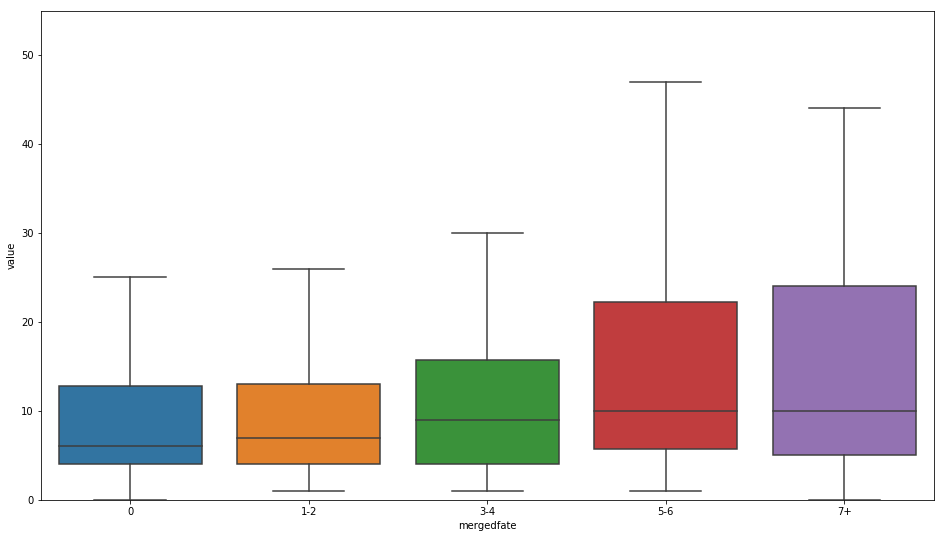

In [45]:
# Phyloty. stage:
plt.figure(figsize=(16,9))
sns.boxplot( data=dre_melt[dre_melt.variable == '8som'], 
           y='value',
           x='mergedfate',
           order = ['0','1-2','3-4','5-6','7+'],
            
        fliersize=0
           )


plt.ylim((0,55))

(0, 55)

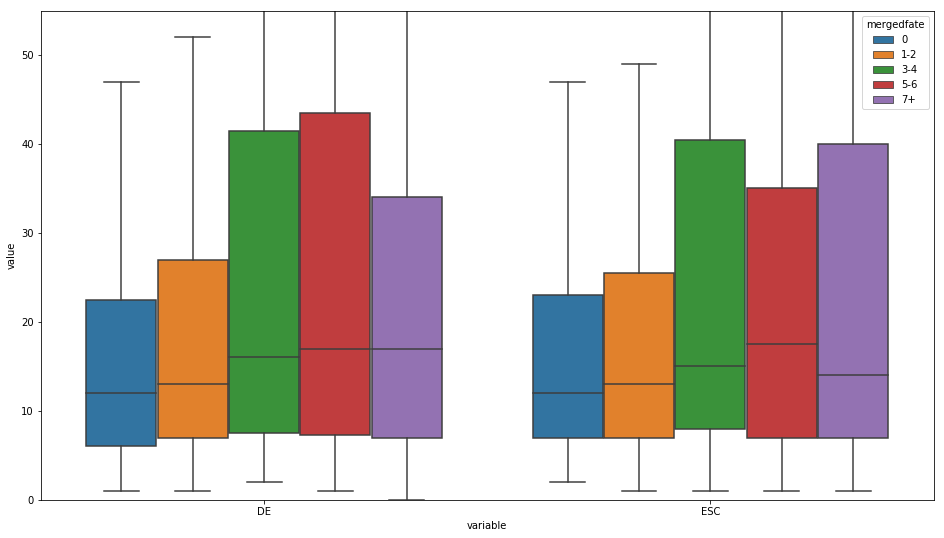

In [47]:
# All stages of zebra:
plt.figure(figsize=(16,9))
sns.boxplot( data=mmu_melt, 
           y='value',
           x='variable',
            hue='mergedfate',
        fliersize=0,
            hue_order = ['0','1-2','3-4','5-6','7+']
           )


plt.ylim((0,55))

(0, 55)

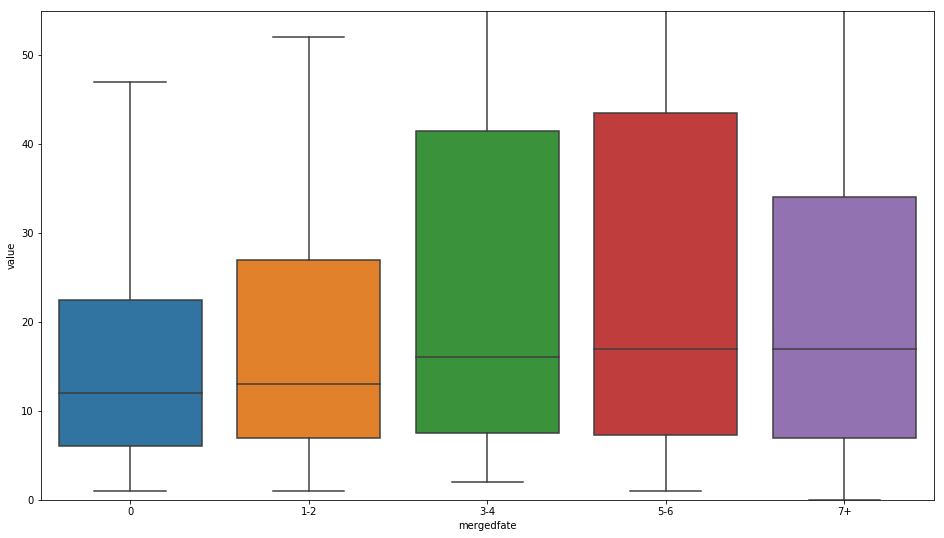

In [50]:
# Phyloty. stage:
plt.figure(figsize=(16,9))
sns.boxplot( data=mmu_melt[mmu_melt.variable == 'DE'], 
           y='value',
           x='mergedfate',
           order = ['0','1-2','3-4','5-6','7+'],
            
        fliersize=0
           )


plt.ylim((0,55))